In [1]:
import gwpy as gwpy
from gwpy.io.gwf import get_channel_names
from gwpy.timeseries import TimeSeries
from gwpy.signal import filter_design
from gwpy.plot import Plot
import pycbc as pycbc
from pycbc import frame
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
import os, glob
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.getcwd()
# full fidelity, 16 KHz data: 'data/O1/H-H1_LOSC_16_V1-1126252544-4096.gwf'
# downsamplesd, 4 kHz data: 'data/O1/H-H1_LOSC_4_V1-1126252544-4096.gwf'
fs = glob.glob('data/O1/*gwf')
print(fs)

['data/O1/H-H1_LOSC_4_V1-1126252544-4096.gwf', 'data/O1/H-H1_LOSC_16_V1-1126252544-4096.gwf', 'data/O1/H-H1_LOSC_16_V1-1126256640-4096.gwf']


In [3]:
f = fs[-1]
print(f)
print(get_channel_names(f))
kdq, kinj, kdata = get_channel_names(f)

print(kdq, kinj, kdata)

data/O1/H-H1_LOSC_16_V1-1126256640-4096.gwf
['H1:GWOSC-16KHZ_R1_DQMASK', 'H1:GWOSC-16KHZ_R1_INJMASK', 'H1:GWOSC-16KHZ_R1_STRAIN']
H1:GWOSC-16KHZ_R1_DQMASK H1:GWOSC-16KHZ_R1_INJMASK H1:GWOSC-16KHZ_R1_STRAIN


In [4]:
tmin = 1126256640 + 36*60
deltat = 30*60#32#0.015

sgfirst = 1126259462 + 0.2 # this signal
tmin = sgfirst
deltat = 4
tmax = tmin + deltat

#series = TimeSeries.read(f, kdata)
series = TimeSeries.read(f, kdata)#, start=tmin, end=tmax)
series_dq = TimeSeries.read(f, kdq)#, start=tmin, end=tmax)
series_inj = TimeSeries.read(f, kinj)#, start=tmin, end=tmax)

In [5]:
# see: https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries
print(series)
print(series.sample_rate)
print(series.t0)
print(series.dt)
print(series.duration)
print(len(series))
print(deltat/series.dt.value)

TimeSeries([1.02359837e-19, 1.00326323e-19, 5.90886188e-20, ...,
            7.23146151e-20, 9.23441383e-20, 9.61257301e-20]
           unit: dimensionless,
           t0: 1126256640.0 s,
           dt: 6.103515625e-05 s,
           name: H1:GWOSC-16KHZ_R1_STRAIN,
           channel: H1:GWOSC-16KHZ_R1_STRAIN)
16384.0 Hz
1126256640.0 s
6.103515625e-05 s
4096.0 s
67108864
65536.0


# Plot time series

In [6]:
def plot_series(series, xlims=None, ylims=None, title='time series', ylabel='Amplitude [strain]'):
    plot = series.plot(title='LIGO-Hanford, %s'%(title), ylabel=ylabel, color='gwpy:ligo-hanford')
    #print(plot.axes[0])
    if xlims is not None:
        plot.axes[0].set_xlim(xlims[0], xlims[1])
    if ylims is not None:
        plot.axes[0].set_ylim(ylims[0], ylims[1])
    plot.show()

Look at quality flag  
**NOTE:** seems to be too simplistic--just tells you whether data was taken or not. More detailed status available from DQ channel of gwf file, as in following cell.

In [7]:
'''
from gwpy.segments import DataQualityFlag
segs = DataQualityFlag.fetch_open_data('H1_DATA', tmin, tmax)
plot = segs.plot(color='gwpy:ligo-hanford')
plot.show()
'''

"\nfrom gwpy.segments import DataQualityFlag\nsegs = DataQualityFlag.fetch_open_data('H1_DATA', tmin, tmax)\nplot = segs.plot(color='gwpy:ligo-hanford')\nplot.show()\n"

Inspect quality flags from DQ channel of gwf file itself. The flags are set in 1 s intervals only.  
**0**:DATA, **1**:CBC_CAT1, **2**:CBC_CAT2, **3**:CBC_CAT3, **4**:BURST_CAT1, **5**:BURST_CAT2, **6**:BURST_CAT3  
An integer value of `127` denotes highest DQ tier (CBC_CAT3), and `63` denotes second DQ tier (CBC_CAT2)  
**IMPORTANT:** Passing the highest DQ tier does **not** mean the data is glitch-free  
Ref: https://www.gw-openscience.org/archive/dataset/O1/

In [8]:
'''
# Uncomment to print out individual bits
nDQbits = 7
# get int32-converted bits
bits = series_dq.value
print(len(bits))
print(bits[0])
print(type(bits[0]))
# NOTE: doing series_dq[0].value returns float64 instead, which cannot be bit shifted

# Print out int32-convert bit array, and list values of individual DQ bits
for i,bit in enumerate(bits[:10]):
    bitvals = [((bit >> ik) & 1) for ik in range(nDQbits)]
    print(i, bit, bitvals)
'''

'\n# Uncomment to print out individual bits\nnDQbits = 7\n# get int32-converted bits\nbits = series_dq.value\nprint(len(bits))\nprint(bits[0])\nprint(type(bits[0]))\n# NOTE: doing series_dq[0].value returns float64 instead, which cannot be bit shifted\n\n# Print out int32-convert bit array, and list values of individual DQ bits\nfor i,bit in enumerate(bits[:10]):\n    bitvals = [((bit >> ik) & 1) for ik in range(nDQbits)]\n    print(i, bit, bitvals)\n'

The same can be done for the injection bits, which say whether or not there was an injected signal, and if so, of which kind  
An integer value of 31 means there was no injected signal of any kind.  
**0**:NO_CBC_HW_INJ **1**:NO_BURST_HW_INJ **2**:NO_DETCHAR_HW_INJ **3**:NO_CW_HW_INJ **4**:NO_STOCH_HW_INJ  
Ref: https://www.gw-openscience.org/archive/dataset/O1/

In [9]:
'''
# Uncomment to print out individual bits
nInjbits = 5
# get int32-converted bits
bits = series_inj.value
print(len(bits))
print(bits[0])
print(type(bits[0]))
# NOTE: doing series_inj[0].value returns float64 instead, which cannot be bit shifted

# Print out int32-convert bit array, and list values of individual injection bits
for i,bit in enumerate(bits[:10]):
    bitvals = [((bit >> ik) & 1) for ik in range(nInjbits)]
    print(i, bit, bitvals)
'''

'\n# Uncomment to print out individual bits\nnInjbits = 5\n# get int32-converted bits\nbits = series_inj.value\nprint(len(bits))\nprint(bits[0])\nprint(type(bits[0]))\n# NOTE: doing series_inj[0].value returns float64 instead, which cannot be bit shifted\n\n# Print out int32-convert bit array, and list values of individual injection bits\nfor i,bit in enumerate(bits[:10]):\n    bitvals = [((bit >> ik) & 1) for ik in range(nInjbits)]\n    print(i, bit, bitvals)\n'

Make time series plots of data, DQ status, and injection status

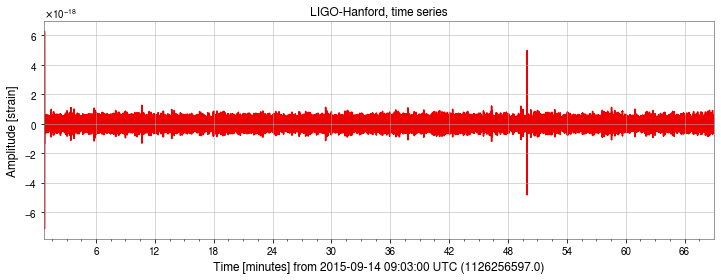

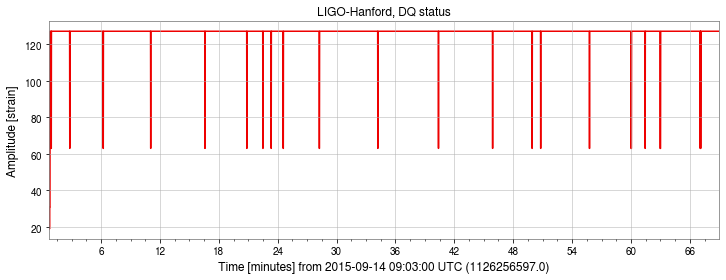

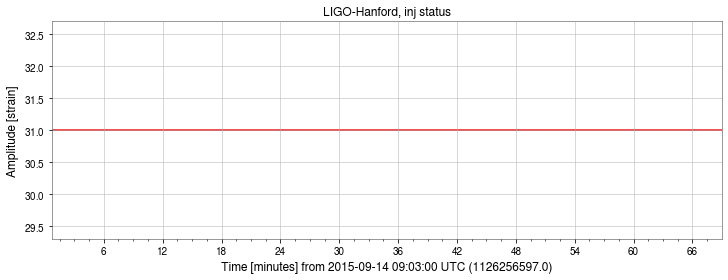

In [10]:
plot_series(series)
plot_series(series_dq, title='DQ status')
plot_series(series_inj, title='inj status')

We can zoom in on the spike...

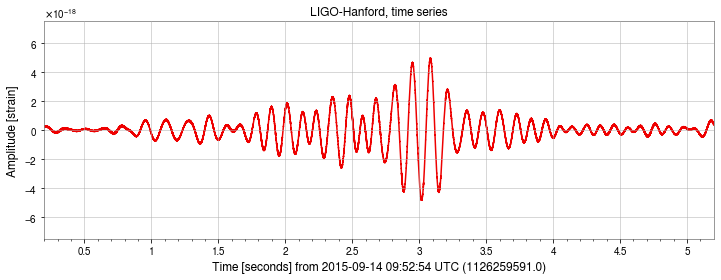

In [11]:
#first = 1126259462 + 0.2 # actual signal
first = 1126259591 + 0.2 # the glitch
last = first + 5
plot_series(series.crop(first, last), ylims=[-7.5e-18, 7.5e-18])

In fact, that is **not** the binary black hole (BBH) merger signal, a.ka., GW. Just another glitch...

# Frequency domain

Look at the amplitude spectral density (ASD), a.k.a., the frequency spectrum

In [12]:
def plot_asd(series, w=(4,2), xlims=None, ylims=None):
    asd = series.asd(*w)
    # => delta_f = 1/4 = 0.25 Hz
    plot = asd.plot(title='LIGO-Hanford, amplitude spectral density (ASD)', ylabel=r'ASD [$\sqrt{Hz}$]', color='gwpy:ligo-hanford')
    #print(plot.axes[0])
    if xlims is not None:
        plot.axes[0].set_xlim(xlims[0], xlims[1])
    if ylims is not None:
        plot.axes[0].set_ylim(ylims[0], ylims[1])
    plot.show()

def plot_psd(series, w=(4,2), xlims=None, ylims=None):
    # see: https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.psd
    psd = series.psd(*w) # = (total_time_duration=sgdelta_t, stride_overlap=2 (default calculated internally as appropriate for window fn))
    # => delta_f = 1/4 = 0.25 Hz
    plot = psd.plot(title='LIGO-Hanford, power spectral density (PSD)', ylabel=r'PSD [Hz]', color='gwpy:ligo-hanford')
    #plot.axes[1].set_ylim(1e-20, 1e-15)
    if xlims is not None:
        plot.axes[0].set_xlim(xlims[0], xlims[1])
    if ylims is not None:
        plot.axes[0].set_ylim(ylims[0], ylims[1])
    plot.show()
    return psd

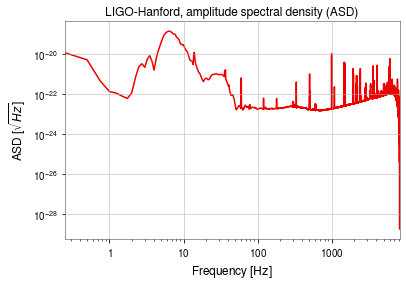

In [13]:
plot_asd(series)

However, O1 data is not calibrated below 10 Hz or above 5 kHz (2 kHz for data at 4 kHz), so apply low pass and high pass filter, a.k.a., bandpass filter:  
Ref: https://www.gw-openscience.org/O1/

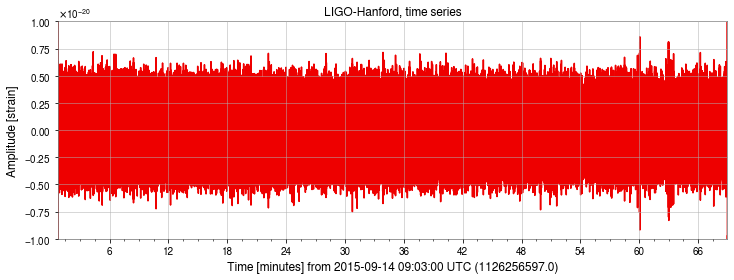

In [14]:
fcalib_lo, fcalib_hi = 16., 600. # Hz
series_bp = series.bandpass(fcalib_lo, fcalib_hi) # or .highpass(fcalib_lo).lowpass(fcalib_hi)
plot_series(series_bp, ylims=[-1.e-20, 1.e-20])#ylims=[-7.5e-19, 7.5e-19])

Look at frequency domain again

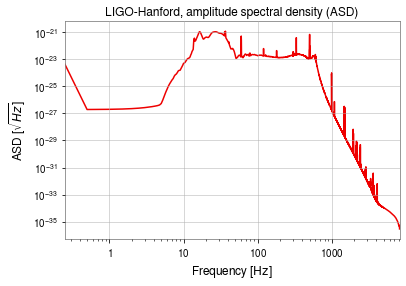

In [15]:
plot_asd(series_bp)

Zoom in on bandpassed range

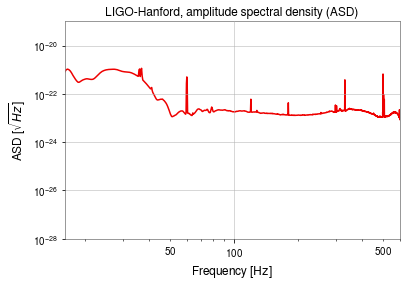

In [16]:
plot_asd(series_bp, xlims=[fcalib_lo, fcalib_hi], ylims=[1.e-28, 1.e-19])

# Matched filtering
Apply matched filtering to find interesting points

0.25 Hz


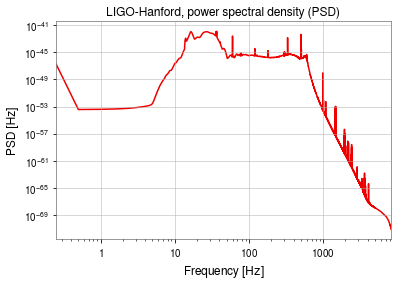

In [17]:
# Get background PSD
# Since, this is a Fourier transform, the freq resolution will be a function of the input time series duration,
# so pick a bg duration equal to sg duration, or set th fft window to a reasonable one like delta_t = 4 s, as above
# this ensures the PSD resolution/step size is delta_f = 1 / delta_t
psd = plot_psd(series_bp)
print(psd.df) # gwpy

In [18]:
print(psd.xindex)
print(psd.xspan)
print(len(psd))

[0.00000e+00 2.50000e-01 5.00000e-01 ... 8.19150e+03 8.19175e+03
 8.19200e+03] Hz
[0.0 ... 8192.25)
32769


In [19]:
# Calculate freq domain of signal GW template
hp, hc = get_fd_waveform(approximant="IMRPhenomD", mass1=40, mass2=32, #f_lower=fcalib_lo, delta_f=psd.df.value)
                         f_lower=fcalib_lo, f_final=psd.xindex[-1].value, delta_f=psd.df.value)
                         #f_lower=fsg_lo, f_final=fsg_hi, delta_f=psd.df.value)

# Should be identical to the psd.df below
print(hp.delta_f) # pycbc

0.25


In [20]:
print(len(series_bp), len(psd), len(hp), len(series_bp)//2 +1)

67108864 32769 32769 33554433


In [21]:
t0 = series_bp.t0.value
delta_t = 4
nsteps = int(series_bp.duration.value//delta_t)
print('t0:',t0)
print('tf:',t0+series_bp.duration.value)
print('nsteps:',nsteps)

# if you dont use the psd from nearby segments, sensitivity is greatly reduced
# the matched filter must also occur in strides otherwise the sg could land one the window edge
# conclusion: very computationally expensive to implement exhaustively

for i in range(nsteps):
    if i%100 == 0: print('.. %d / %d'%(i, nsteps))
    tfirst = t0 + i*delta_t
    tlast = tfirst + deltat
    '''if i > 1:
        if i != 704:
            print(i, tfirst, tlast)
            break
        else:
            continue'''
    #if 1126259460 < tfirst:
    #    print(i, tfirst, tlast)
    #    break
    #else: 
    #    continue
    #'''
    #batch = series_bp.crop(tfirst, tlast)
    #snr_ = matched_filter(hp, batch.to_pycbc(), psd=psd.to_pycbc(), low_frequency_cutoff=fcalib_lo)
    #snr_ = TimeSeries.from_pycbc(snr_).abs()
    if i == 705:
        print(i, tfirst, tlast)
        batch = series_bp.crop(tfirst, tlast)
        print(batch.duration)
        # PSD needs its own time window for good FFT,
        # which is distinct from matched filtering template window,
        # which is instead connected to GW signal duration!
        # what a mess!
        #psd = batch.psd(4,2)
        #psd = series_bp.psd(4, 2)
        psd = series_bp.crop(tfirst-32, tfirst).psd(4, 2)
        snr_ = matched_filter(hp, batch.to_pycbc(), psd=psd.to_pycbc(), low_frequency_cutoff=fcalib_lo)
        snr_ = TimeSeries.from_pycbc(snr_).abs()
        snrs = snr_.copy()
    else:
        continue
        #snrs.append(snr_.copy())
    #if i > 10: break
    #'''
print('Done.')

t0: 1126256640.0
tf: 1126260736.0
nsteps: 1024
.. 0 / 1024
.. 100 / 1024
.. 200 / 1024
.. 300 / 1024
.. 400 / 1024
.. 500 / 1024
.. 600 / 1024
.. 700 / 1024
705 1126259460.0 1126259464.0
4.0 s
.. 800 / 1024
.. 900 / 1024
.. 1000 / 1024
Done.


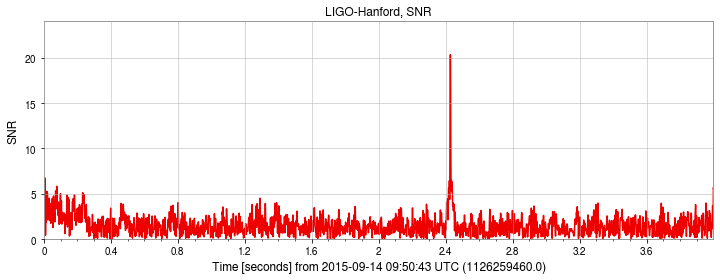

In [22]:
plot_series(snrs, title='SNR', ylabel='SNR', ylims=[0., 24.])#, xlims=[1126259462.2, 1126259462.2+4])

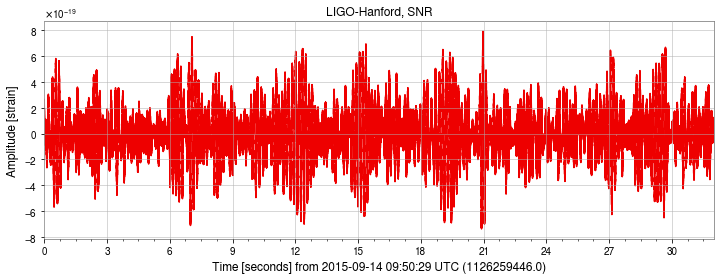

In [23]:
# In practice, the ROI is determined from peaks in the SNR from the matched filter
# But this is exceedinly computationally expensive to implement, so we will cheat...
# We need 32 s ROI for spectrogram to have sufficient freq range and resolution,
# so expand time window here
#first = 1126259462-16 #series.t0.value
first = 1126259446
last = first + 32
roi = series.crop(first, last)

plot_series(roi, title='SNR')

# Whiten data
Normalize to power density spectrum

In [24]:
def _fft_length_default(dt):
    # from https://github.com/gwpy/gwpy/blob/26f63684db17104c5d552c30cdf01248b2ec76c9/gwpy/timeseries/timeseries.py#L44
    """Choose an appropriate FFT length (in seconds) based on a sample rate
    Parameters
    ----------
    dt : `~astropy.units.Quantity`
        the sampling time interval, in seconds
    Returns
    -------
    fftlength : `int`
        a choice of FFT length, in seconds
    """
    return int(max(2, np.ceil(2048 * dt)))

def whiten_series(series, w=(4,2)):
    # pycbc
    # pycbc does truncation by default
    # comparing: https://github.com/gwpy/gwpy/blob/v2.0.4/gwpy/timeseries/timeseries.py#L1669
    # and https://pycbc.org/pycbc/latest/html/gw150914.html?highlight=whiten + https://pycbc.org/pycbc/latest/html/_modules/pycbc/types/timeseries.html#TimeSeries.whiten
    #series_pycbc = series.to_pycbc()
    #wht = series_pycbc.whiten(series.duration.value, _fft_length_default(series.dt.value))
    #wht = TimeSeries.from_pycbc(wht)
    # gwpy
    wht = series.whiten(*w)
    # truncate corrupted ends
    # from: https://pycbc.org/pycbc/latest/html/_modules/pycbc/types/timeseries.html#TimeSeries.whiten
    max_filter_duration = _fft_length_default(series.dt.decompose().value)
    max_filter_len = int(max_filter_duration * series.sample_rate.decompose().value)
    wht = wht[int(max_filter_len/2):-int(max_filter_len/2)]
    return wht

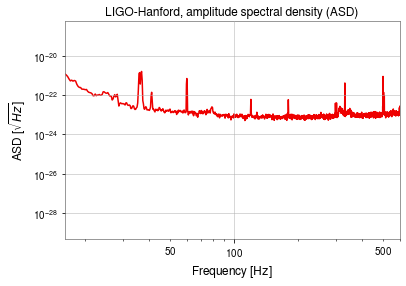

In [25]:
plot_asd(roi, xlims=[fcalib_lo, fcalib_hi])#, ylims=[1.e-28, 1.e-19])

491520


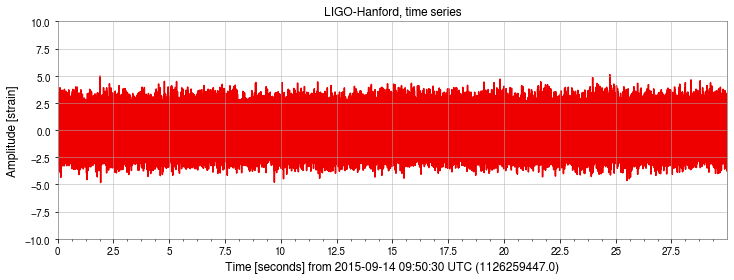

In [26]:
# apply whitening to pre-bandpassed waveform, since we will apply bandpass again after whitening
wht = whiten_series(roi)
plot_series(wht, ylims=[-10., 10.])
print(len(wht))

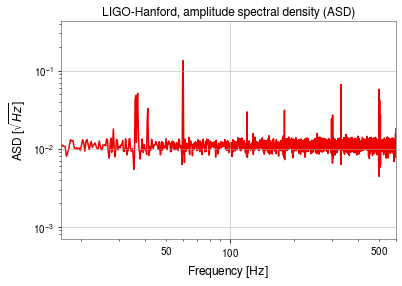

In [27]:
plot_asd(wht, xlims=[fcalib_lo, fcalib_hi])#, ylims=[1.e-28, 1.e-19])

Apply basic analysis-level bandpass  
Different refs use different ranges, but in general, should be optimized to frequency spectrum of signal  
Refs: https://www.gw-openscience.org/tutorial_bandpass/, https://pycbc.org/pycbc/latest/html/gw150914.html, https://gwpy.github.io/docs/stable/examples/signal/gw150914.html

In [28]:
fsg_lo, fsg_hi = 35., 250. # Hz
'''
# Uncomment to apply basic bandpass filter only
wht = wht.bandpass(fsg_lo, fsg_hi) # or .highpass(fsg_lo).lowpass(fsg_hi)
plot_series(wht, ylims=[-0.75, 0.75])
'''

'\n# Uncomment to apply basic bandpass filter only\nwht = wht.bandpass(fsg_lo, fsg_hi) # or .highpass(fsg_lo).lowpass(fsg_hi)\nplot_series(wht, ylims=[-0.75, 0.75])\n'

Alternatively, chain (1) bandpass and (2) notch removal at harmonics of AC power supply (60 Hz, 120 Hz, 180 Hz, ...), into a single ZPK filter    
Ref: https://gwpy.github.io/docs/stable/examples/signal/gw150914.html, https://pycbc.org/pycbc/latest/html/gw150914.html

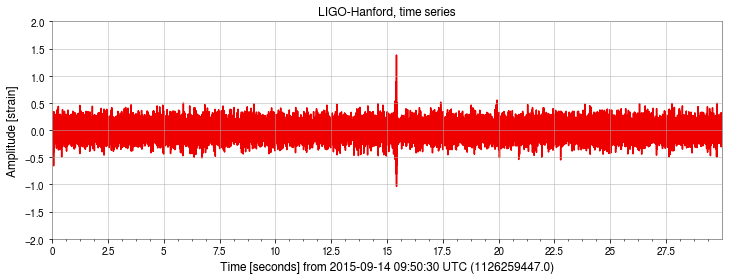

In [29]:
#'''
# define bandpass
bp = filter_design.bandpass(fsg_lo, fsg_hi, series.sample_rate)
# define notches
notches = [filter_design.notch(line, series.sample_rate) for line in (60, 120, 180)]
# chain filters
zpk = filter_design.concatenate_zpks(bp, *notches)
# set filtfilt=True to filter both backwards and forwards to preserve the correct phase at all frequencies
# see also: https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.filter
wht = wht.filter(zpk, filtfilt=True)
#'''
plot_series(wht, ylims=[-2., 2.])

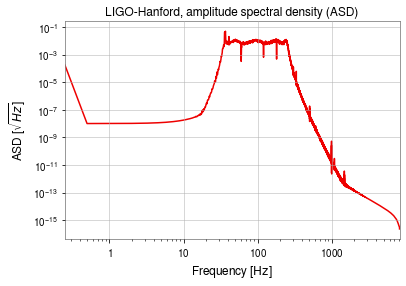

In [30]:
plot_asd(wht)

Zooming in on the spike in time series...

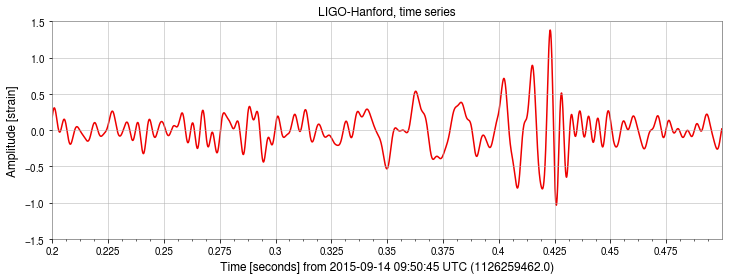

In [31]:
#sgfirst = 1126259591 + 0.2 # the first glitch
sgfirst = 1126259462 + 0.2 # this signal
#sgfirst = 1126258757 + 16*60 + 6 + 0.3 # another glitch
sgdelta_t = 0.3
sglast = sgfirst + sgdelta_t

plot_series(wht.crop(sgfirst, sglast), ylims=[-1.5, 1.5])

Which, indeed, is the merger signal GW

The same segment in the pre-whitened (but bandpassed) time series looks very different

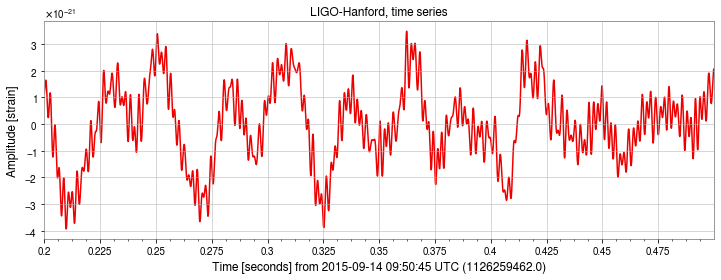

In [32]:
plot_series(series_bp.crop(sgfirst, sglast))#, ylims=[-1.e-19, 1.e-19])

# Making spectrograms

In [33]:
def plot_qt(qt, xlims=None, ylims=None):
    plot = qt.plot(title='LIGO-Hanford, Q-transform spectrogram', yscale='log')
    #print(plot.axes[0])
    if xlims is not None:
        plot.axes[0].set_xlim(xlims[0], xlims[1])
    if ylims is not None:
        plot.axes[0].set_ylim(ylims[0], ylims[1])
    plot.colorbar(cmap='viridis', label='Normalized energy')
    plot.show()

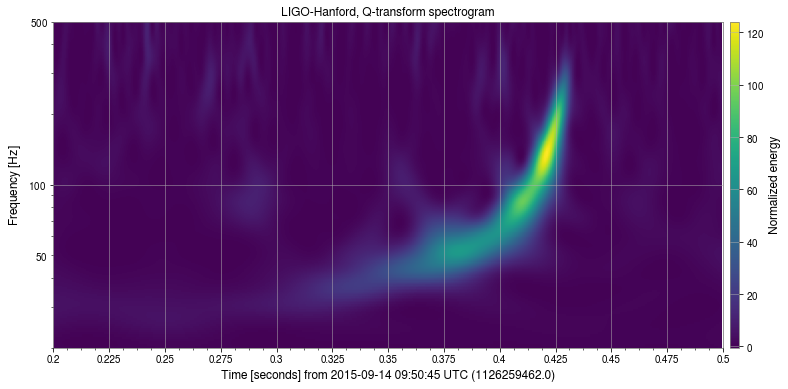

In [34]:
# Save computation/memory by only calculating **output** spectrogram on time segment of interest
# WARNING: Need to use sufficiently large time window around **input** waveform 
# in order to get good freq resolution in Fourier decomposition: about sg +/- 16 s
qt = roi.q_transform(outseg=(sgfirst, sglast))
plot_qt(qt, ylims=[20., 500.])